# 03. Dividindo as matrizes em batches

Do README.md
>**(II)** The next step would be to divide the extracted CSI file into multiple samples each having 50 packets.  <br/>
>
>**For ```coarse``` and ```proximity``` tests, execute ```csi2batches_SimWiSense.m```** <br/>
><br/>
>==> For ```proximity``` and ```coarse``` test, change the ```Test='xxxx'``` field of the script to ```Test='proximity'``` and  ```Test='coarse'``` respectively.  <br/>
>
><br/>
><br/>
>
>**For ```fine_grained``` Test, execute ```csi2batches_SimWiSense_fine_grained.m```** <br/>
><br/>
>Please change ```monitor ="xx"``` field to ```monitor ="m1"``` or ```monitor ="m2"``` or ```monitor ="m3"``` for different monitors which will simultaneously classify human activities. 
><br/>

Para os testes 'proximity' e 'coarse'
- No código existe o parâmetro chamado window_size que está setado com o valor 50.
- Também especifica os subconjuntos para cada tipo de teste.
  - Proximity: Train_m1, Test_m1, Train_m2, Test_m2, Train_m3, Test_m3
  - Coarse: Train, Test 


O código varre os arquivos .mat do passo anterior e salva dentro das pastas slots

O código define:
- O tamanho da janela, window_size, que  representa a quantidade de amostras que vai ficar em cada batch, arquivo. Aqui ele está usando 50 amostras.
- Também define quais são os slots, ou conjuntos. Por exemplo: train, test no caso do coarse e train_m1, test_m1, ..., train_m3, test_m3 no caso do proximty. Abaixo uma visualização dos slots.
- Na hora de definir esses os índices desses slots ele define que o número de amostras do arquivo fonte equivale a 814 (número mágico) e define os índices com razões desse valor.
- Os índices não começam de zero. Também é uma pequena distância (em amostras) em conjuntos de train e test.


- Para cada uma das 264 matrizes, ele quebra em x batches. Os arquives de cada batch corresponde a região definida no slot, onde cada arquivo vai ser da dimenssão (50x242). Sendo que ele descarta 5 'janelas' (5*50 amostras) no início e no final do slot.

- Não encontrei aqui nenhuma normalização e nem alinhamento.

- Aqui, é selecionado um subconjunto de toda captura



In [55]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

def plot_slots(data, title):
  df = pd.DataFrame(data)
  df['Duration'] = (df['End'] - df['Start'])

  fig, ax = plt.subplots(1, figsize=(10, 5))

  for i in range(len(df)):
    ax.barh(y=i, width=df['Duration'][i], left=df['Start'][i], height=0.5)

  # Setting labels and ticks
  ax.set_yticks(range(len(df)))
  ax.set_yticklabels(df['Task'])

  ax.set_xlabel('Sample ratio index')
  ax.set_xlim(0, 814)

  # Invert y-axis to show tasks from top to bottom
  ax.invert_yaxis()

  # Add grid lines
  ax.grid(axis='x', linestyle='--')

  # Set title
  plt.title(title)

  # Show the plot
  plt.show()

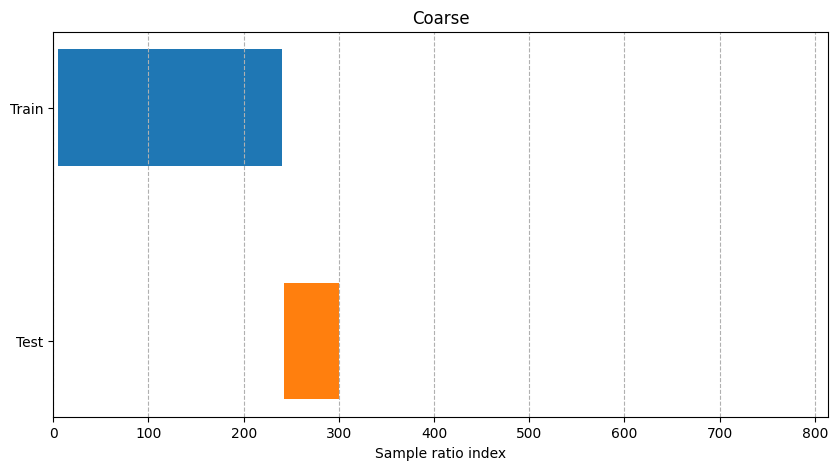

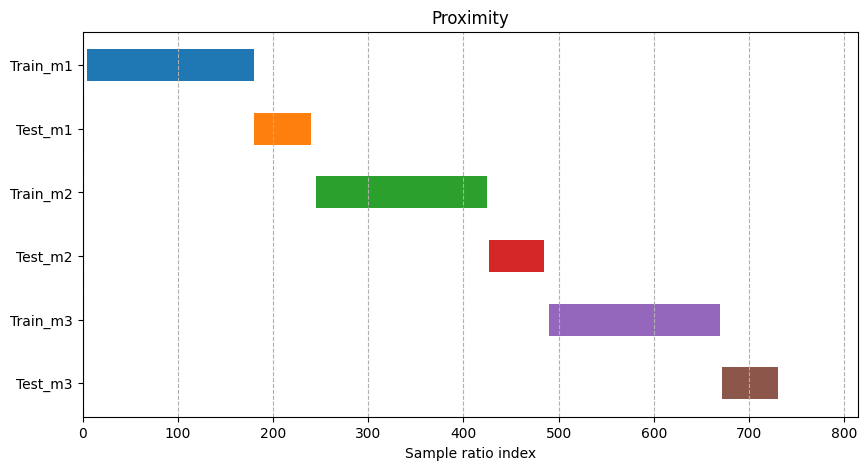

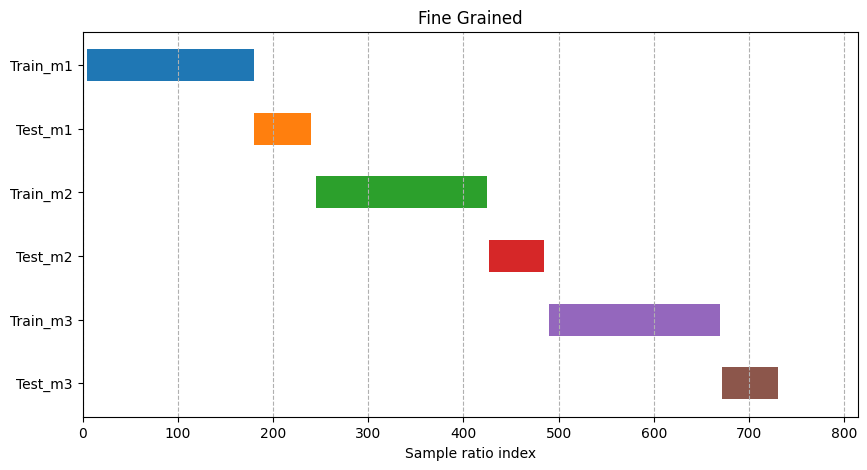

In [56]:
proximity_data = {
  'Task': ["Train_m1", "Test_m1", "Train_m2", "Test_m2", "Train_m3", "Test_m3"],
  'Start': [5, 180, 245, 427, 490, 672],
  'End': [180, 240, 425, 485, 670, 730]
}

coarse_data = {
  'Task': ["Train", "Test"],
  'Start': [5, 242],
  'End': [240, 300]
}

fine_grained = {
  'Task': ["Train_m1", "Test_m1", "Train_m2", "Test_m2", "Train_m3", "Test_m3"],
  'Start': [5, 180, 245, 427, 490, 672],
  'End': [180, 240, 425, 485, 670, 730]    
}
plot_slots(coarse_data, "Coarse")
plot_slots(proximity_data, "Proximity")
plot_slots(fine_grained, "Fine Grained")


In [57]:
import pandas as pd
import scipy.io
from pathlib import Path
from tqdm import tqdm

df_proto = {
  'test': [],
  'environment': [],
  'monitor': [],
  'slot': [],
  'activity': [],
  'shape0': [],
  'shape1': [],
  'file_path': []
}

def getShape(mat_file_path):
  data = scipy.io.loadmat(mat_file_path)
  return data['csi_mon'].shape


file_paths = Path('../Data').rglob('*.mat')

for file_path in tqdm(sorted(file_paths)):
  file_path = str(file_path)

  if 'Slots' in file_path:
    file_path_splited = file_path.split('/')
    test = file_path_splited[2]
    environment = file_path_splited[3]
    monitor = file_path_splited[6]
    slot = file_path_splited[8]
    activity = file_path_splited[9].split('_')[0]
    shape0, shape1 = getShape(file_path)
    file_path = file_path_splited[10]
    df_proto['test'].append(test)
    df_proto['environment'].append(environment)
    df_proto['monitor'].append(monitor)
    df_proto['slot'].append(slot)
    df_proto['activity'].append(activity)
    df_proto['shape0'].append(shape0)
    df_proto['shape1'].append(shape1)
    df_proto['file_path'].append(file_path)


100%|██████████| 2496667/2496667 [22:04<00:00, 1885.06it/s]


In [58]:
pd.DataFrame(df_proto).to_csv('SAIDAS/03-batch_summary.csv', index=False)


# Qual a relação entre a quantidade de dados extraídos e os dados utilizados aqui?

In [59]:
mat_original = pd.read_csv('SAIDAS/02-mat_summary.csv')
batches = pd.read_csv('SAIDAS/03-batch_summary.csv')

n_pacotes_original = mat_original['shape1'].sum()
n_pacotes_apos_batches = batches['shape0'].sum()

In [60]:
print(f"Pacotes originais: {n_pacotes_original}")
print(f"Pacotes após batches: {n_pacotes_apos_batches}")
print(f'Diferença: {n_pacotes_original - n_pacotes_apos_batches} pacotes')
print(f'Redução de {(n_pacotes_original - n_pacotes_apos_batches) / n_pacotes_original * 100:.2f}%')
print(f'O número de pacotes do batches correspondem a {n_pacotes_apos_batches / n_pacotes_original * 100:.2f}% do número de pacotes originais')

Pacotes originais: 218927963
Pacotes após batches: 124820150
Diferença: 94107813 pacotes
Redução de 42.99%
O número de pacotes do batches correspondem a 57.01% do número de pacotes originais


# Quantos arquivos batches para cada slot? Quantos pacotes?

In [61]:
# group batches dataframe by test, environment, monitor, slot, activity
# count files in file_path
# sum shape0
# max shape1
batches_grouped = batches.groupby(['test', 'environment', 'monitor', 'slot']).agg(
  nr_batches=('file_path', 'count'),
  nr_packets=('shape0', 'sum'),
  nr_subcarriers=('shape1', 'max'),
).reset_index()


In [62]:
batches_grouped

,test,environment,monitor,slot,nr_batches,nr_packets,nr_subcarriers
0,coarse,Classroom,m1,Test,2244,112200,242
1,coarse,Classroom,m1,Train,9207,460350,242
2,coarse,Classroom,m2,Test,2247,112350,242
3,coarse,Classroom,m2,Train,9222,461100,242
4,coarse,Classroom,m3,Test,2258,112900,242
5,coarse,Classroom,m3,Train,9264,463200,242
6,coarse,Office,m1,Test,2309,115450,242
7,coarse,Office,m1,Train,9470,473500,242
8,coarse,Office,m2,Test,2447,122350,242
9,coarse,Office,m2,Train,10033,501650,242


In [63]:
batches_grouped.to_csv('SAIDAS/03-batch_summary_grouped.csv', index=False)

In [65]:
batches_grouped

,test,environment,monitor,slot,nr_batches,nr_packets,nr_subcarriers
0,coarse,Classroom,m1,Test,2244,112200,242
1,coarse,Classroom,m1,Train,9207,460350,242
2,coarse,Classroom,m2,Test,2247,112350,242
3,coarse,Classroom,m2,Train,9222,461100,242
4,coarse,Classroom,m3,Test,2258,112900,242
5,coarse,Classroom,m3,Train,9264,463200,242
6,coarse,Office,m1,Test,2309,115450,242
7,coarse,Office,m1,Train,9470,473500,242
8,coarse,Office,m2,Test,2447,122350,242
9,coarse,Office,m2,Train,10033,501650,242
